## Eliminating biased word embedding association

In this experiment we show that replacing using a fair metric (EXPLORE) on the word embedding space eliminated most biases in word embeddings

### Word embedding association test

Developed by [Caliskan et al. (2017)](https://arxiv.org/pdf/1608.07187.pdf) to evaluate semantic biases in word embeddings, WEATs are inspired by implicit association tests (IAT) from the psychometric literature. Lt $X, Y$ be two sets of word embeddings of target words of equal size (e.g. African-American and European-American names respectively), and $A, B$ be two sets of attribute words (e.g. words with positive and negative sentiments respectively).

For each word $x \in X$, we measure its association with the attribute by:
$$ s(x, A, B) \triangleq \frac{1}{|A|} \sum_{a \in A} \frac{\langle x, a \rangle}{||x|| ||a||} - \frac{1}{|B|} \sum_{b \in B} \frac{\langle x, b \rangle}{||x|| ||b||} $$

If $x$ tends to be associated with the attribute (e.g. it has positive or negative sentiment), then we expect $s(x, A, B)$ to be far from zero. To measure the association of $X$ with the attribute, we average the associations of the word in $X$:

$$ s(X, A, B) \triangleq \frac{1}{|X|} \sum_{x \in X} s(x, A, B) $$


#### Steps:
1. Download the `sentiment_data` folder from the following GitHub repo into the `data` local folder: https://github.com/debarghya-mukherjee/Fair_metric_learning/tree/5333cbd35c3d8febcc9fc25a59a453b6c3cc0c88
1. Download the `embeddings` folder from the following Github repo into the `embeddings` local folder: https://github.com/debarghya-mukherjee/Fair_metric_learning/tree/5333cbd35c3d8febcc9fc25a59a453b6c3cc0c88

In [1]:
import sys, os
sys.path.append("../../")

In [2]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from inFairness.distances import EXPLOREDistance
from inFairness.utils import datautils

# import data loading script
import data
import utils

In [3]:
DATAPATH = "./data/"
EMBEDPATH = "./data/sentiment_glove.42B.300d.txt"
TEST_EMBEDPATH = "./embeddings/"

# `ALL_TESTS` defines the words X, Y, A, and B used for association tests
ALL_TESTS = [
    ['flowers', 'insects', 'pleasant', 'unpleasant'],
    ['instruments', 'weapons', 'pleasant', 'unpleasant'],
    ['mental', 'physical', 'temporal', 'permanent'],
    ['white', 'black', 'pleasant', 'unpleasant'],
    ['white7', 'black7', 'pleasant', 'unpleasant'],
    ['white7', 'black7', 'pleasant9', 'unpleasant9'],
    ['male_names', 'female_names', 'career', 'family'],
    ['math', 'arts', 'male_terms', 'female_terms'],
    ['science10', 'arts10', 'male_terms10', 'female_terms10'],
    ['young', 'old', 'pleasant9', 'unpleasant9'],
]

TEST_IDS = [
    'FLvINS-PLvUPL', 'INSvWPN-PLvUPL', 'MENvPHY-TEMPvPERM',
    'WHTvBLK-PLvUPL', 'WHT7vBLK7-PLvUPL', 'WHT7vBLK7-PL9vUPL9',
    'MALEvFEM-CARvFAM', 'MATHvARTS-MALEvFEM', 'SCvART-MALEvFEM', 
    'YNGvOLD-PLvUPL'
]

In [4]:
_, X, y, vocab, all_names_embed, names = data.load_data(DATAPATH, EMBEDPATH, names_path=DATAPATH)

In [5]:
# Create comparable pairs

n_pairs_comparable = 50000
unique_names_idx = np.unique(names, return_index=True)[1]
pairs_idx = datautils.generate_data_pairs(
    n_pairs=n_pairs_comparable, datasamples_1=unique_names_idx
)

comparable_X1 = all_names_embed[unique_names_idx[pairs_idx[:, 0]]]
comparable_X2 = all_names_embed[unique_names_idx[pairs_idx[:, 1]]]


# Create incomparable pairs
n_pairs_incomparable = 50000
comparator_fn = lambda x1, x2: (x1 == 1) and (x2 == -1)
pairs_idx = datautils.generate_data_pairs(
    n_pairs_comparable, y, comparator=comparator_fn
)

incomparable_X1 = X[pairs_idx[:, 0]]
incomparable_X2 = X[pairs_idx[:, 1]]


# Join the two sets (comparable and incomparable) to create X and Y
X1 = np.vstack((comparable_X1, incomparable_X1))
X2 = np.vstack((comparable_X2, incomparable_X2))

Y_pairs = np.zeros(n_pairs_comparable + n_pairs_incomparable)
Y_pairs[:n_pairs_comparable] = 1

In [6]:
X1 = torch.from_numpy(X1)
X2 = torch.from_numpy(X2)
Y_pairs = torch.from_numpy(Y_pairs)

In [7]:
metric = EXPLOREDistance()
metric.fit(X1, X2, Y_pairs, iters=1000, batchsize=10000)
sigma = metric.sigma.detach().numpy()

In [8]:
methods = {
    'baseline': [None, None],
    'explore': [sigma, None]
}

In [9]:
result = []

for idx, testset in enumerate(ALL_TESTS):
    X_name, Y_name, A_name, B_name = testset
    print('Association test %d: target words are %s and %s; attribute words are %s and %s' % (idx, X_name, Y_name, A_name, B_name))

    X_embed = np.load(TEST_EMBEDPATH + X_name + '_embed.npy')
    Y_embed = np.load(TEST_EMBEDPATH + Y_name + '_embed.npy')
    A_embed = np.load(TEST_EMBEDPATH + A_name + '_embed.npy')
    B_embed = np.load(TEST_EMBEDPATH + B_name + '_embed.npy')

    for method_name, method_params in methods.items():
        method_sigma, method_proj = method_params
        p_val, effect = utils.run_test(
            X_embed, Y_embed, A_embed, B_embed, Sigma=method_sigma, proj=method_proj
        )

        result.append(
            [idx, TEST_IDS[idx], method_name, p_val, effect]
        )

result = pd.DataFrame(result, columns=['index', 'testname', 'method', 'p_val', 'effect_size'])

Association test 0: target words are flowers and insects; attribute words are pleasant and unpleasant
Association test 1: target words are instruments and weapons; attribute words are pleasant and unpleasant
Association test 2: target words are mental and physical; attribute words are temporal and permanent
Association test 3: target words are white and black; attribute words are pleasant and unpleasant
Association test 4: target words are white7 and black7; attribute words are pleasant and unpleasant
Association test 5: target words are white7 and black7; attribute words are pleasant9 and unpleasant9
Association test 6: target words are male_names and female_names; attribute words are career and family
Association test 7: target words are math and arts; attribute words are male_terms and female_terms
Association test 8: target words are science10 and arts10; attribute words are male_terms10 and female_terms10
Association test 9: target words are young and old; attribute words are plea

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'FLvINS-PLvUPL'),
  Text(1, 0, 'INSvWPN-PLvUPL'),
  Text(2, 0, 'MENvPHY-TEMPvPERM'),
  Text(3, 0, 'WHTvBLK-PLvUPL'),
  Text(4, 0, 'WHT7vBLK7-PLvUPL'),
  Text(5, 0, 'WHT7vBLK7-PL9vUPL9'),
  Text(6, 0, 'MALEvFEM-CARvFAM'),
  Text(7, 0, 'MATHvARTS-MALEvFEM'),
  Text(8, 0, 'SCvART-MALEvFEM'),
  Text(9, 0, 'YNGvOLD-PLvUPL')])

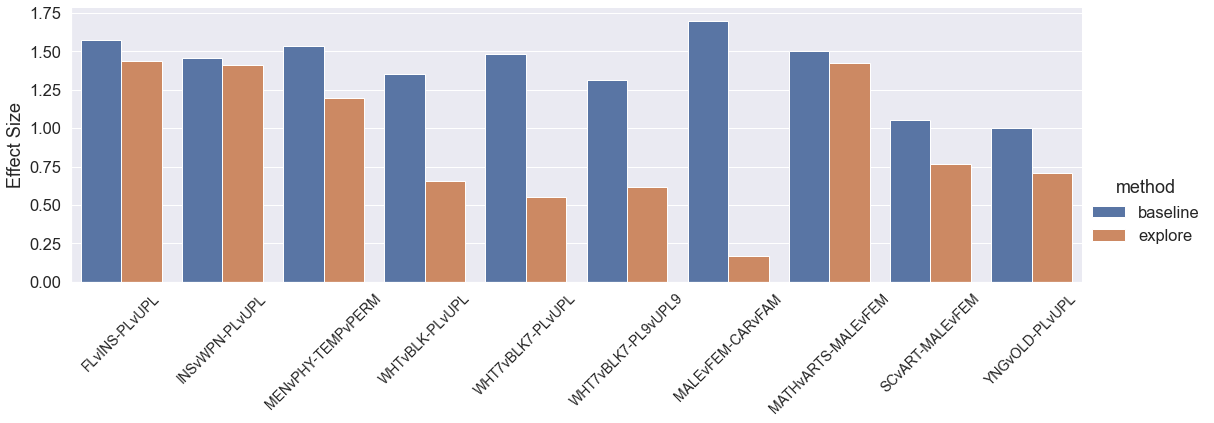

In [10]:
sns.set(font_scale=1.5)
barplot = sns.catplot(x='testname', y='effect_size', hue='method', data=result, kind='bar', aspect=3.1)
barplot.set_axis_labels("", "Effect Size")
plt.xticks(fontsize=14, rotation=45)